# Forecasting electricity demand with Daily, Weekly and Monthly

## Libraries

The libraries used in this document are:

In [9]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Helligdage
#===============================================================================
from datetime import date
import holidays

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Dataen anvendt i dette dokument er blevet indhentet fra EnergiDataService.dk og DMI.dk. Datasættet indholder 3 kolonner and 159.767 observationer. Informationen for hver kolonne er:

* HourDK: Dato og tidspunkt for observationen.

* GrossConsumptionMWh: Energiforbrug (MW).

* temp_max_past1h: gennemsnits temperatur for hele landet (DK).


In [10]:
# Indlæsning af data
Data = pd.read_csv("C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Data/Forbrug og Vejr Data.csv")

# Vælg kun nødvendige kolonner og kopier DataFrame
Forbrug_og_temp = Data[['HourDK', 'GrossConsumptionMWh', 'temp_max_past1h']].copy()

# Konverter 'HourDK' til datetime format og sæt som index
Forbrug_og_temp['HourDK'] = pd.to_datetime(Forbrug_og_temp['HourDK'])
Forbrug_og_temp.set_index('HourDK', inplace=True)

print(Forbrug_og_temp)

                     GrossConsumptionMWh  temp_max_past1h
HourDK                                                   
2005-01-01 00:00:00          3237.832763         2.350000
2005-01-01 01:00:00          3101.580811         2.134545
2005-01-01 02:00:00          2963.392211         2.023636
2005-01-01 03:00:00          2854.805420         2.066667
2005-01-01 04:00:00          2838.514649         1.954545
...                                  ...              ...
2023-05-30 17:00:00          3935.964505        16.416364
2023-05-30 18:00:00          3764.163099        15.803704
2023-05-30 19:00:00          3655.639568        15.183333
2023-05-30 20:00:00          3663.715933        13.750000
2023-05-30 21:00:00          3308.564927        12.239286

[159767 rows x 2 columns]


In [3]:
# Fylder manglende værdier
Forbrug_og_temp = Forbrug_og_temp.resample('H').asfreq()

# Erstat manglende værdier med interpolation
Forbrug_og_temp.interpolate(method='linear', inplace=True)

Forbrug_og_temp=Forbrug_og_temp[:len(Forbrug_og_temp)-22]

#Tilføjer helligdage til dataframen
dk_holidays = holidays.DK(years=range(2005, 2024))
# Vi skaber en ny kolonne, der markerer om dagen i hver time er en helligdag
dk_holidays_dates = [date for date in dk_holidays.keys()]
Forbrug_og_temp['Holiday'] = [1 if d in dk_holidays_dates else 0 for d in Forbrug_og_temp.index.date]

Forbrug_og_temp

,GrossConsumptionMWh,temp_max_past1h,Holiday
HourDK,,,
2005-01-01 00:00:00,3237.832763,2.350000,1
2005-01-01 01:00:00,3101.580811,2.134545,1
2005-01-01 02:00:00,2963.392211,2.023636,1
2005-01-01 03:00:00,2854.805420,2.066667,1
2005-01-01 04:00:00,2838.514649,1.954545,1
...,...,...,...
2023-05-29 19:00:00,3644.378019,12.391071,1
2023-05-29 20:00:00,3452.577998,11.371698,1
2023-05-29 21:00:00,3271.591882,10.537736,1


## aggregering

Vi har nu vores datasæt for timeligt dette skal kopieres til 3 nye dataframes, for de 3 aggreveringer

* `Forbrug_og_temp_daily`
* `Forbrug_og_temp_weekly`
* `Forbrug_og_temp_monthly`

Danglish long leve!

In [4]:
# Konverterer 'Holiday' til daglig frekvens
Forbrug_og_temp['Holiday'] = Forbrug_og_temp['Holiday'].resample('D').max()

# Dagligt data
Forbrug_og_temp_daily = Forbrug_og_temp.resample('D').agg(
    {'GrossConsumptionMWh': 'sum', 
     'temp_max_past1h': 'mean', 
     'Holiday': 'max'})
print(Forbrug_og_temp_daily)

# Ugentligt data
Forbrug_og_temp_weekly = Forbrug_og_temp.resample('W').agg(
    {'GrossConsumptionMWh': 'sum', 
     'temp_max_past1h': 'mean', 
     'Holiday': lambda x: (x > 0).sum()})
Forbrug_og_temp_weekly.index = Forbrug_og_temp_weekly.index.to_period('W')
print(Forbrug_og_temp_weekly)

# Månedligt data
Forbrug_og_temp_monthly = Forbrug_og_temp.resample('M').agg(
    {'GrossConsumptionMWh': 'sum', 
     'temp_max_past1h': 'mean', 
     'Holiday': lambda x: (x > 0).sum()})
Forbrug_og_temp_monthly.index = Forbrug_og_temp_monthly.index.to_period('M')
print(Forbrug_og_temp_monthly)

            GrossConsumptionMWh  temp_max_past1h  Holiday
HourDK                                                   
2005-01-01         84488.348024         3.517958      1.0
2005-01-02         91385.152712         3.949927      0.0
2005-01-03        112312.543822         4.343384      0.0
2005-01-04        114629.267213         6.551546      0.0
2005-01-05        113532.201418         4.758494      0.0
...                         ...              ...      ...
2023-05-25         93864.130226        11.163726      0.0
2023-05-26         91501.063552        10.481420      0.0
2023-05-27         79366.346107        10.866656      0.0
2023-05-28         80490.098766        11.418121      1.0
2023-05-29         83015.119601        11.152402      1.0

[6723 rows x 3 columns]
                       GrossConsumptionMWh  temp_max_past1h  Holiday
HourDK                                                              
2004-12-27/2005-01-02        175873.500736         3.733943        1
2005-01-03/200

Som det kan ses for det ugenlig data, så har vi nogen problemer i enderne, vi skal selvfølgelig også tage højde for at datasættene for ugentlig og månedlig forbrug starter og slutter, i dette eksempel kan vi nøjes med at manipulere det ugenlige pga. de datoer vi opdeler i senere

In [5]:
# Find den første mandag i eller efter 2005-01-01
first_monday = next((idx.start_time for idx in Forbrug_og_temp_weekly.index if idx.start_time.weekday() == 0 and idx.start_time >= pd.Timestamp('2005-01-01')), None)

# Find den sidste søndag i eller før 2023-05-29
last_sunday = next((idx.end_time for idx in reversed(Forbrug_og_temp_weekly.index) if idx.end_time.weekday() == 6 and idx.end_time <= pd.Timestamp('2023-05-29')), None)

# Find den første uge der indeholder first_monday
first_full_week = next((idx for idx in Forbrug_og_temp_weekly.index if idx.start_time == first_monday), None)

# Find den sidste uge der indeholder last_sunday
last_full_week = next((idx for idx in reversed(Forbrug_og_temp_weekly.index) if idx.end_time == last_sunday), None)

# Skær det ufuldstændige data fra begyndelsen og slutningen af dit datasæt
Forbrug_og_temp_weekly = Forbrug_og_temp_weekly.loc[first_full_week:last_full_week]
print(Forbrug_og_temp_weekly)


                       GrossConsumptionMWh  temp_max_past1h  Holiday
HourDK                                                              
2005-01-03/2005-01-09        748757.240359         5.932621        0
2005-01-10/2005-01-16        742867.273917         4.733791        0
2005-01-17/2005-01-23        758442.628176         2.863935        0
2005-01-24/2005-01-30        779864.847294         0.147573        0
2005-01-31/2005-02-06        754081.625733         2.712043        0
...                                    ...              ...      ...
2023-04-24/2023-04-30        675922.956286         6.552692        0
2023-05-01/2023-05-07        655356.916397         7.468537        1
2023-05-08/2023-05-14        621207.662727        11.968612        0
2023-05-15/2023-05-21        616122.294037        10.489866        1
2023-05-22/2023-05-28        625928.031557        11.636457        1

[960 rows x 3 columns]


## Opdeling i Træning, Validering og Test

Nu kan vi opdeler vores 3 datasæt i 3 sæt et trænings sæt, et validerings sæt og et test sæt

In [6]:
end_train = '2017-05-01'
end_validation = '2022-11-30'

data_train_daily = Forbrug_og_temp_daily.loc[: end_train, :].copy()
data_val_daily   = Forbrug_og_temp_daily.loc[end_train:end_validation, :].copy()
data_test_daily  = Forbrug_og_temp_daily.loc[end_validation:, :].copy()

data_train_weekly = Forbrug_og_temp_weekly.loc[: end_train, :].copy()
data_val_weekly   = Forbrug_og_temp_weekly.loc[end_train:end_validation, :].copy()
data_test_weekly  = Forbrug_og_temp_weekly.loc[end_validation:, :].copy()

data_train_monthly = Forbrug_og_temp_monthly.loc[: end_train, :].copy()
data_val_monthly   = Forbrug_og_temp_monthly.loc[end_train:end_validation, :].copy()
data_test_monthly  = Forbrug_og_temp_monthly.loc[end_validation:, :].copy()

print(f"Train dates for daily       : {data_train_daily.index.min()} - {data_train_daily.index.max()}  (n={len(data_train_daily)})")
print(f"Validation dates for daily  : {data_val_daily.index.min()} - {data_val_daily.index.max()}  (n={len(data_val_daily)})")
print(f"Test dates for daily        : {data_test_daily.index.min()} - {data_test_daily.index.max()}  (n={len(data_test_daily)})")
print("\n")
print(f"Train dates for weekly      : {data_train_weekly.index.min()} - {data_train_weekly.index.max()}  (n={len(data_train_weekly)})")
print(f"Validation dates for weekly : {data_val_weekly.index.min()} - {data_val_weekly.index.max()}  (n={len(data_val_weekly)})")
print(f"Test dates for weekly       : {data_test_weekly.index.min()} - {data_test_weekly.index.max()}  (n={len(data_test_weekly)})")
print("\n")
print(f"Train dates for monthly     : {data_train_monthly.index.min()} - {data_train_monthly.index.max()}  (n={len(data_train_monthly)})")
print(f"Validation dates for monthly: {data_val_monthly.index.min()} - {data_val_monthly.index.max()}  (n={len(data_val_monthly)})")
print(f"Test dates for monthly      : {data_test_monthly.index.min()} - {data_test_monthly.index.max()}  (n={len(data_test_monthly)})")

Train dates for daily       : 2005-01-01 00:00:00 - 2017-05-01 00:00:00  (n=4504)
Validation dates for daily  : 2017-05-01 00:00:00 - 2022-11-30 00:00:00  (n=2040)
Test dates for daily        : 2022-11-30 00:00:00 - 2023-05-29 00:00:00  (n=181)


Train dates for weekly      : 2005-01-03/2005-01-09 - 2017-05-01/2017-05-07  (n=644)
Validation dates for weekly : 2017-05-01/2017-05-07 - 2022-11-28/2022-12-04  (n=292)
Test dates for weekly       : 2022-11-28/2022-12-04 - 2023-05-22/2023-05-28  (n=26)


Train dates for monthly     : 2005-01 - 2017-05  (n=149)
Validation dates for monthly: 2017-05 - 2022-11  (n=67)
Test dates for monthly      : 2022-11 - 2023-05  (n=7)


## Graphic opdagelse

Når man bygger en forudsigelses model, kan det være brugbart at plotte tidsserien. Dette tillader mønstre såsom trend og seasonality at blive identificeret.

#### Daily

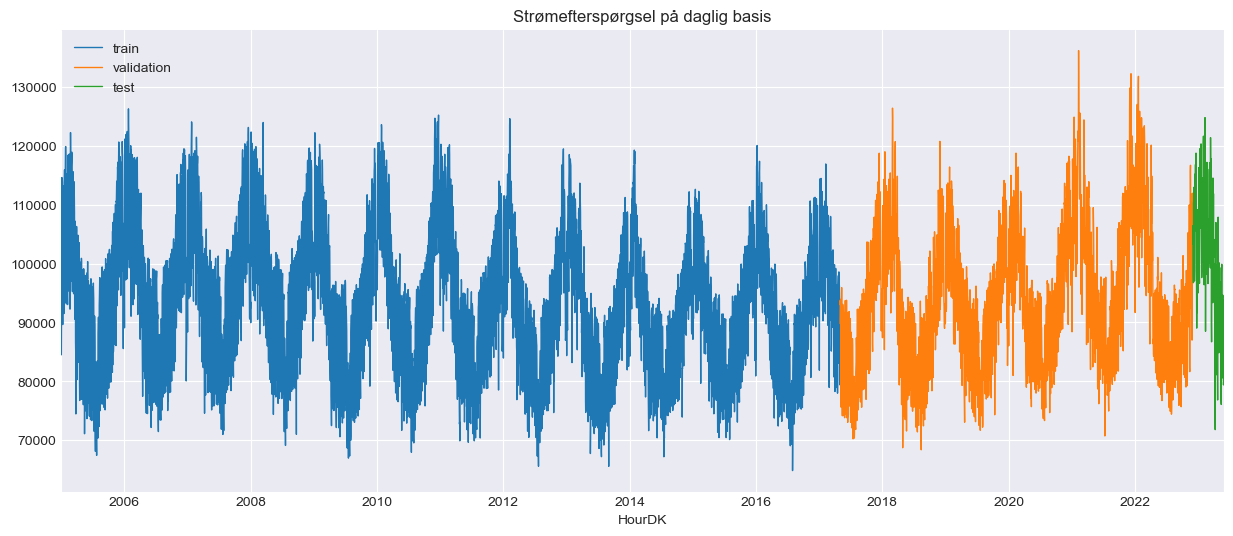

In [7]:
# Time series plot daily
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data_train_daily.GrossConsumptionMWh.plot(ax=ax, label='train', linewidth=1)
data_val_daily.GrossConsumptionMWh.plot(ax=ax, label='validation', linewidth=1)
data_test_daily.GrossConsumptionMWh.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Strømefterspørgsel på daglig basis')
ax.legend();

#### Weekly

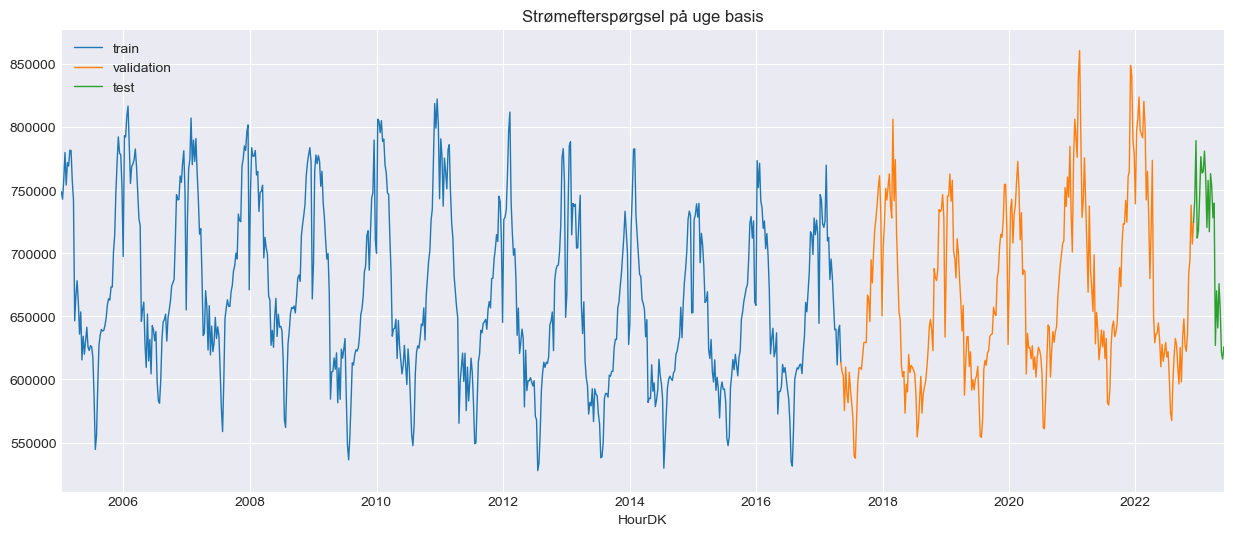

In [8]:
# Time series plot weekly
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data_train_weekly.GrossConsumptionMWh.plot(ax=ax, label='train', linewidth=1)
data_val_weekly.GrossConsumptionMWh.plot(ax=ax, label='validation', linewidth=1)
data_test_weekly.GrossConsumptionMWh.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Strømefterspørgsel på uge basis')
ax.legend();

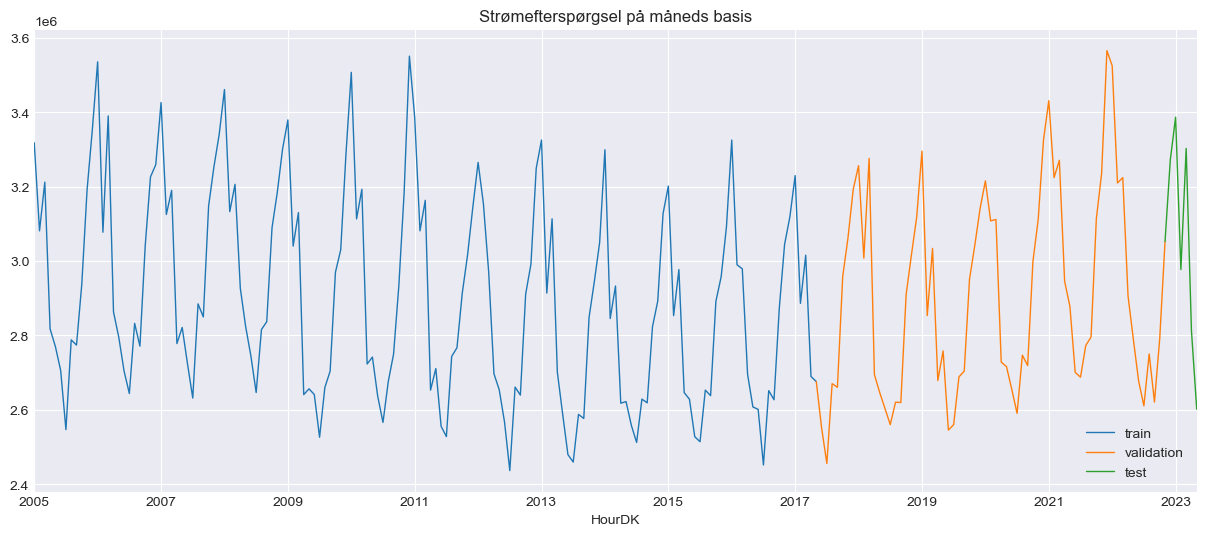

In [9]:
# Time series plot monthly
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data_train_monthly.GrossConsumptionMWh.plot(ax=ax, label='train', linewidth=1)
data_val_monthly.GrossConsumptionMWh.plot(ax=ax, label='validation', linewidth=1)
data_test_monthly.GrossConsumptionMWh.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Strømefterspørgsel på måneds basis')
ax.legend();

### Årlig, ugentlig og daglig seasonality

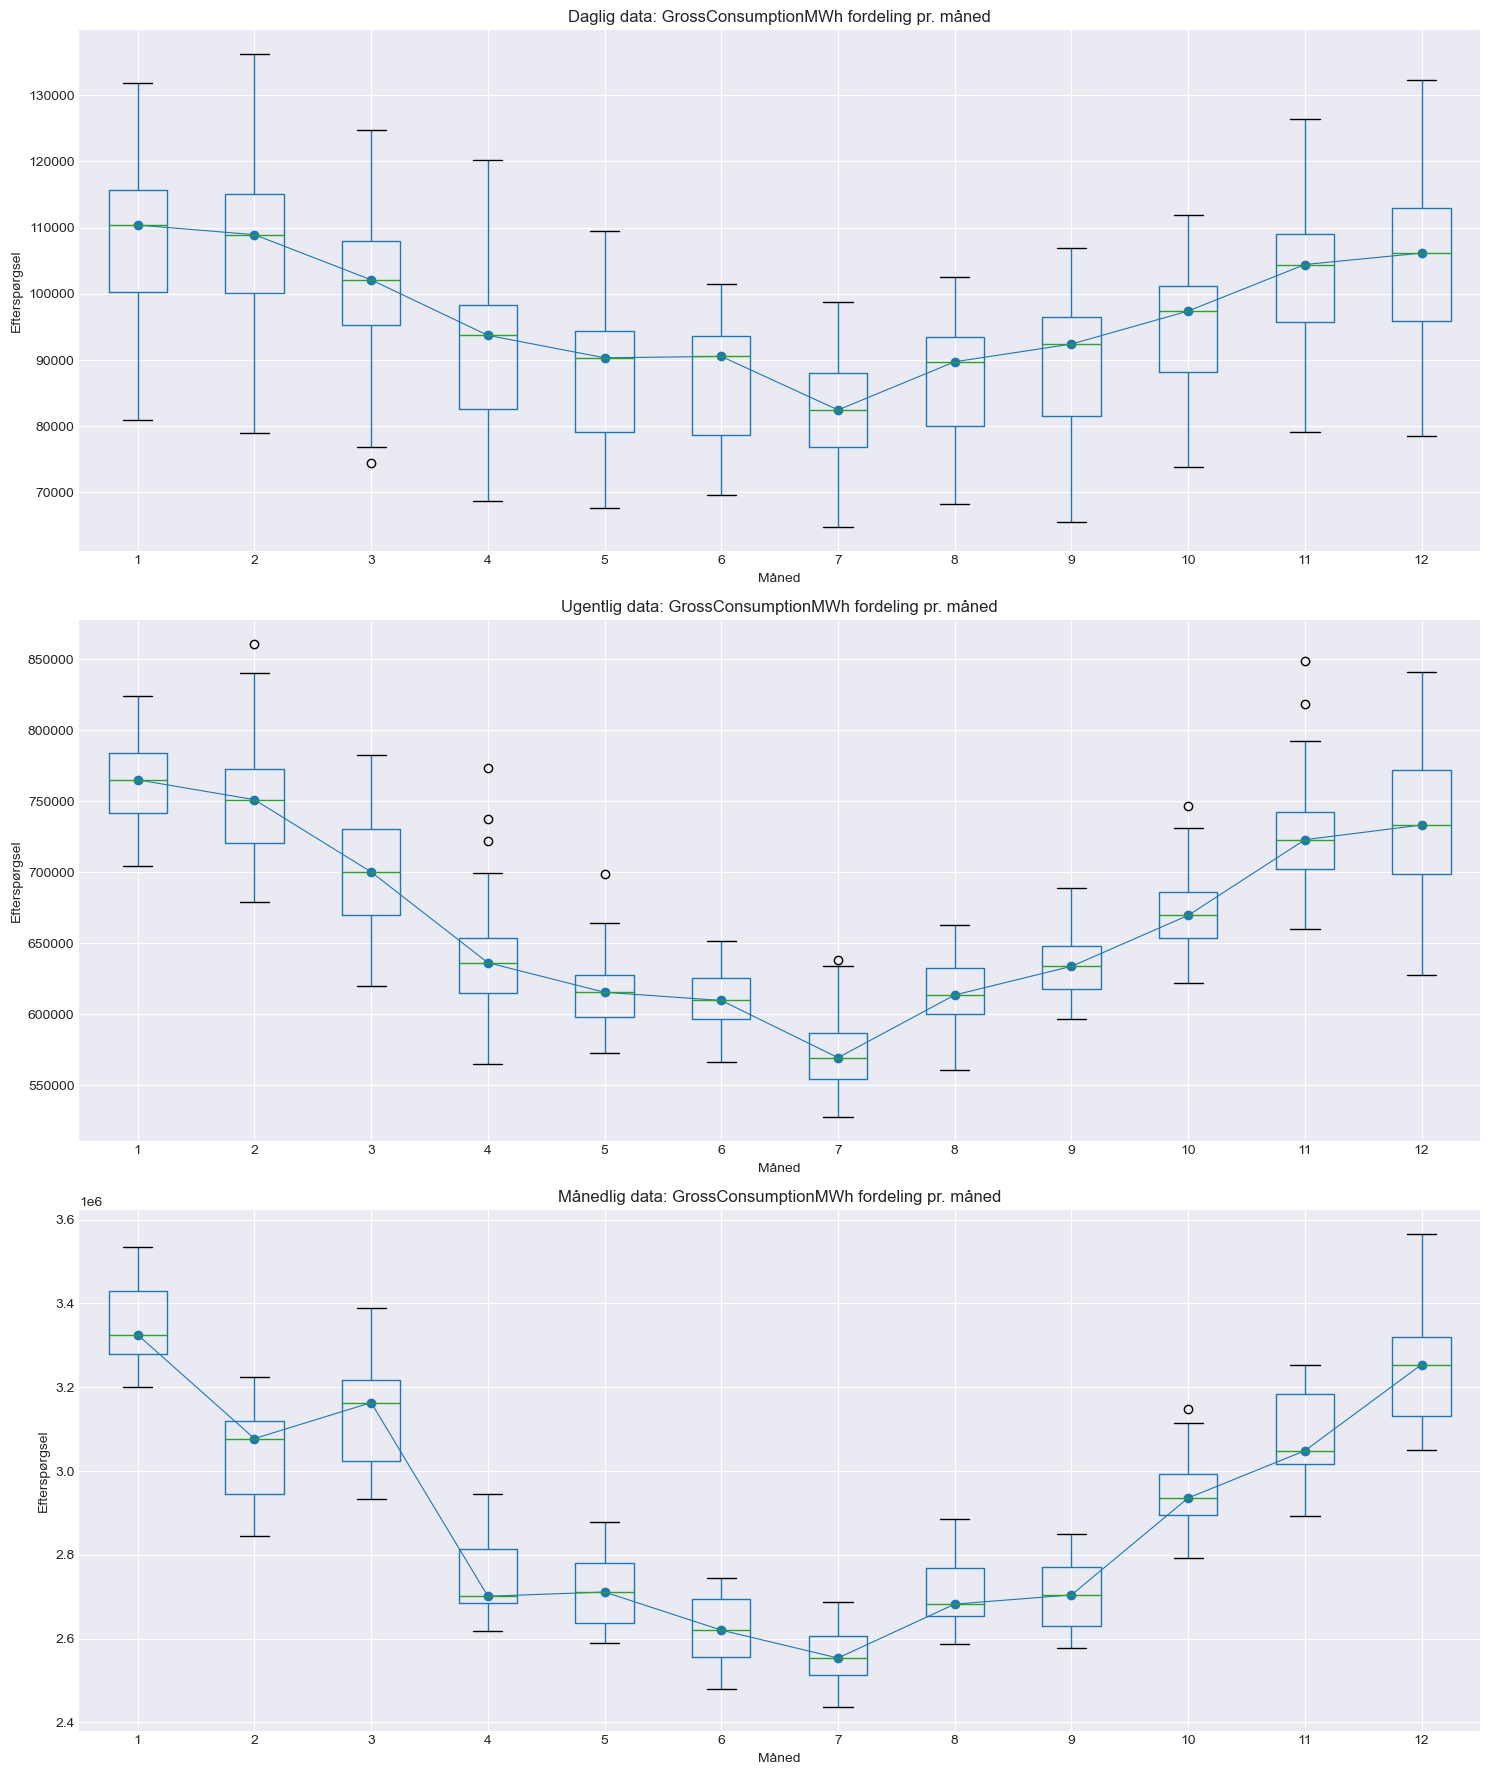

In [10]:
# Tilføj en månedskolonne til hvert datasæt
Forbrug_og_temp_daily['month'] = Forbrug_og_temp_daily.index.month
Forbrug_og_temp_weekly['month'] = [idx.start_time.month for idx in Forbrug_og_temp_weekly.index]
Forbrug_og_temp_monthly['month'] = Forbrug_og_temp_monthly.index.month

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

# Daglig data
Forbrug_og_temp_daily.boxplot(column='GrossConsumptionMWh', by='month', ax=axes[0])
Forbrug_og_temp_daily.groupby('month')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=axes[0])
axes[0].set_ylabel('Efterspørgsel')
axes[0].set_xlabel('Måned')
axes[0].set_title('Daglig data: GrossConsumptionMWh fordeling pr. måned')

# Ugentlig data
Forbrug_og_temp_weekly.boxplot(column='GrossConsumptionMWh', by='month', ax=axes[1])
Forbrug_og_temp_weekly.groupby('month')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=axes[1])
axes[1].set_ylabel('Efterspørgsel')
axes[1].set_xlabel('Måned')
axes[1].set_title('Ugentlig data: GrossConsumptionMWh fordeling pr. måned')

# Månedlig data
Forbrug_og_temp_monthly.boxplot(column='GrossConsumptionMWh', by='month', ax=axes[2])
Forbrug_og_temp_monthly.groupby('month')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=axes[2])
axes[2].set_ylabel('Efterspørgsel')
axes[2].set_xlabel('Måned')
axes[2].set_title('Månedlig data: GrossConsumptionMWh fordeling pr. måned')

# Fjern hovedtitlen
fig.suptitle('')
plt.tight_layout()
plt.show()

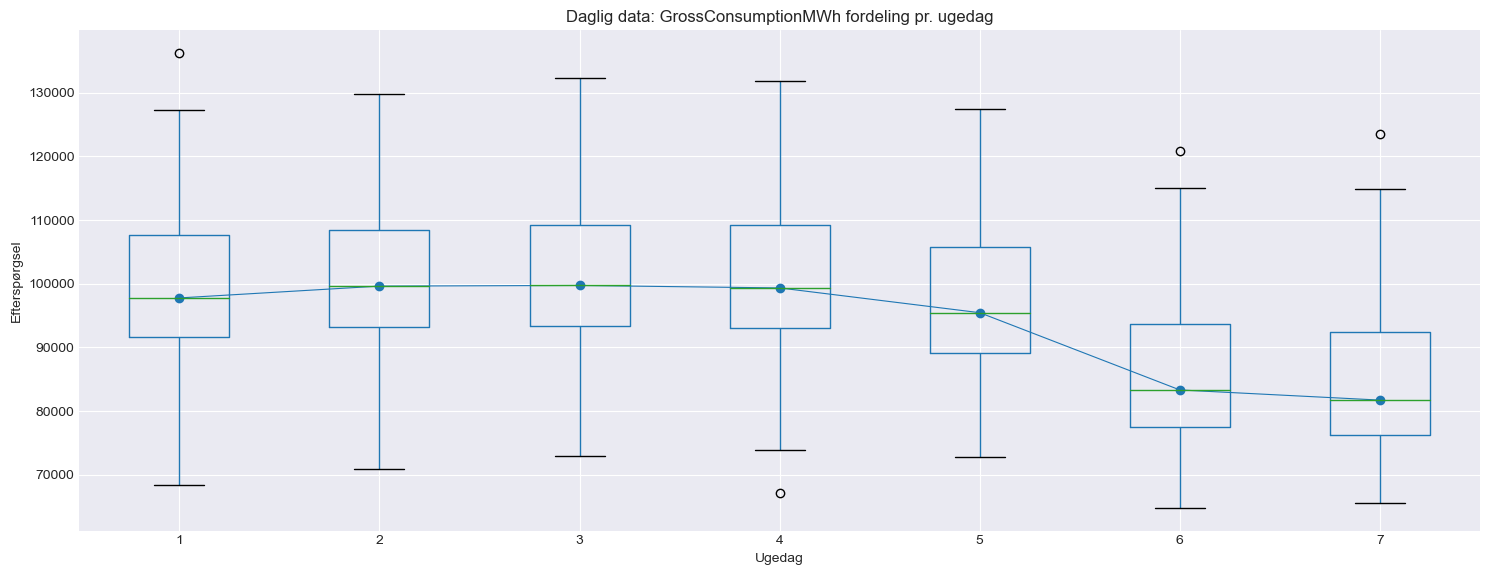

In [11]:
Forbrug_og_temp_daily['week_day'] = Forbrug_og_temp_daily.index.day_of_week + 1

fig, axes = plt.subplots(figsize=(15, 6))

Forbrug_og_temp_daily.boxplot(column='GrossConsumptionMWh', by='week_day', ax=axes)
Forbrug_og_temp_daily.groupby('week_day')['GrossConsumptionMWh'].median().plot(style='o-', linewidth=0.8, ax=axes)
axes.set_ylabel('Efterspørgsel')
axes.set_xlabel('Ugedag')
axes.set_title('Daglig data: GrossConsumptionMWh fordeling pr. ugedag')

# Fjern hovedtitlen
fig.suptitle('')
plt.tight_layout()
plt.show()

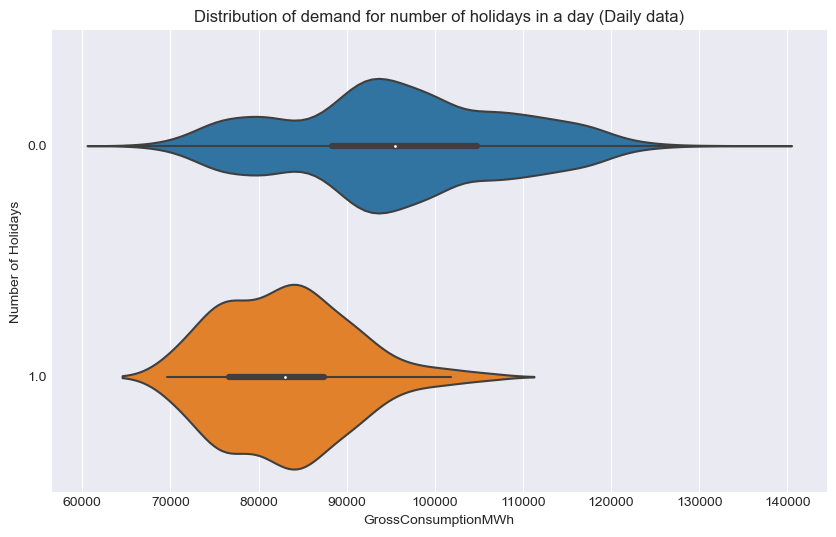

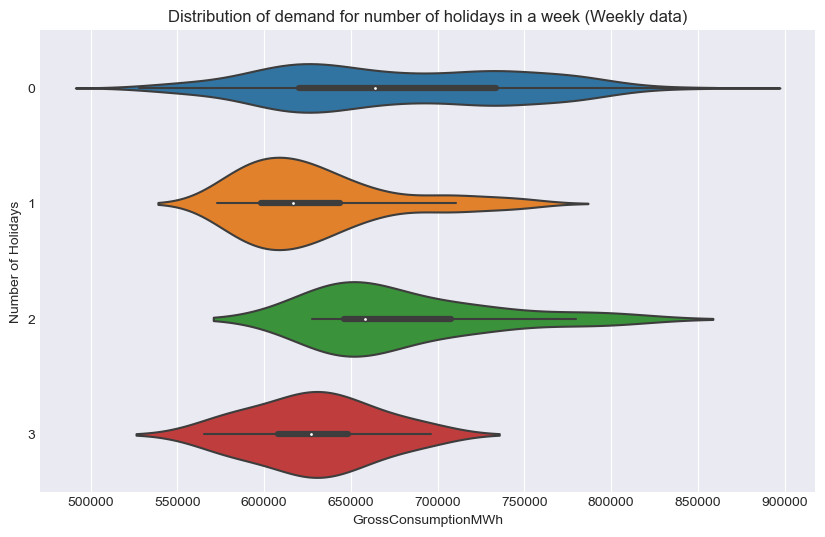

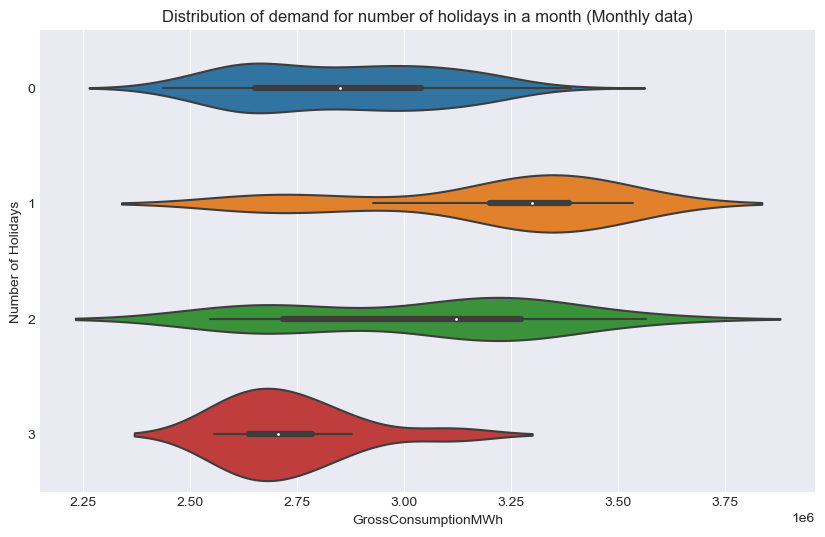

In [12]:
from pandas.api.types import CategoricalDtype

# Opret en ordnet kategori-type
cat_type = CategoricalDtype(categories=sorted(Forbrug_og_temp_daily['Holiday'].unique().astype(str)), ordered=True)

# Daglige data
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    x       = 'GrossConsumptionMWh',
    y       = 'Holiday',
    data    = Forbrug_og_temp_daily.assign(Holiday = Forbrug_og_temp_daily['Holiday'].astype(str).astype(cat_type)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand for number of holidays in a day (Daily data)')
ax.set_xlabel('GrossConsumptionMWh')
ax.set_ylabel('Number of Holidays');

# Gør det samme for ugentlige og månedlige data
cat_type = CategoricalDtype(categories=sorted(Forbrug_og_temp_weekly['Holiday'].unique().astype(str)), ordered=True)

# Ugentlige data
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    x       = 'GrossConsumptionMWh',
    y       = 'Holiday',
    data    = Forbrug_og_temp_weekly.assign(Holiday = Forbrug_og_temp_weekly['Holiday'].astype(str).astype(cat_type)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand for number of holidays in a week (Weekly data)')
ax.set_xlabel('GrossConsumptionMWh')
ax.set_ylabel('Number of Holidays');

# Månedlige data
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(
    x       = 'GrossConsumptionMWh',
    y       = 'Holiday',
    data    = Forbrug_og_temp_monthly.assign(Holiday = Forbrug_og_temp_monthly['Holiday'].astype(str).astype(cat_type)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand for number of holidays in a month (Monthly data)')
ax.set_xlabel('GrossConsumptionMWh')
ax.set_ylabel('Number of Holidays');

som det kan ses så er det tydeligt i det daglige data at der bruges mindre strøm på helligdage. men at når dataen aggregeres til ugentlig og månedlig så forsvinder dette mønstre.

### Autokorrelations plots

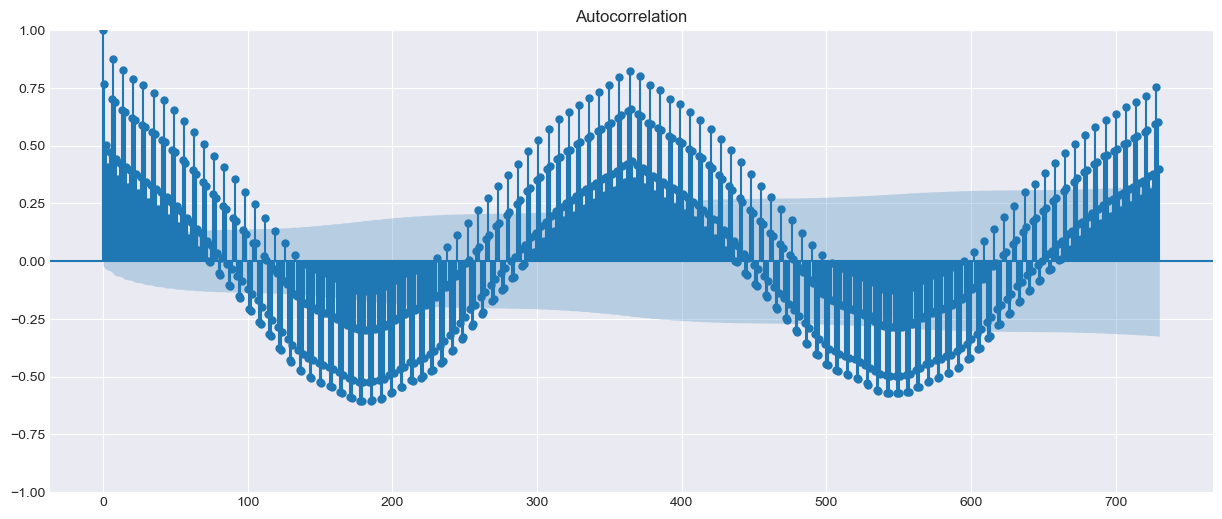

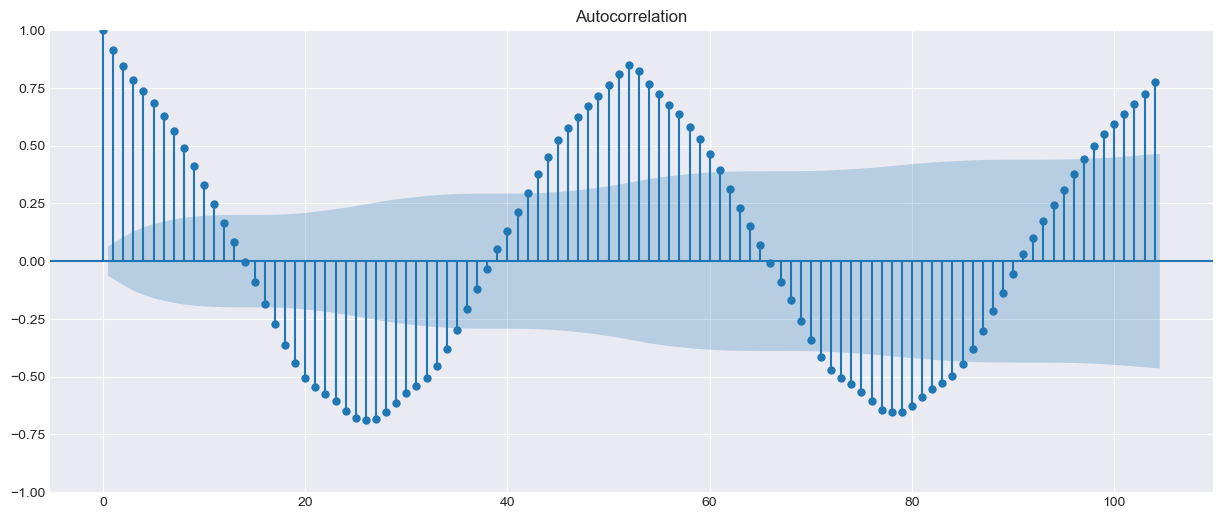

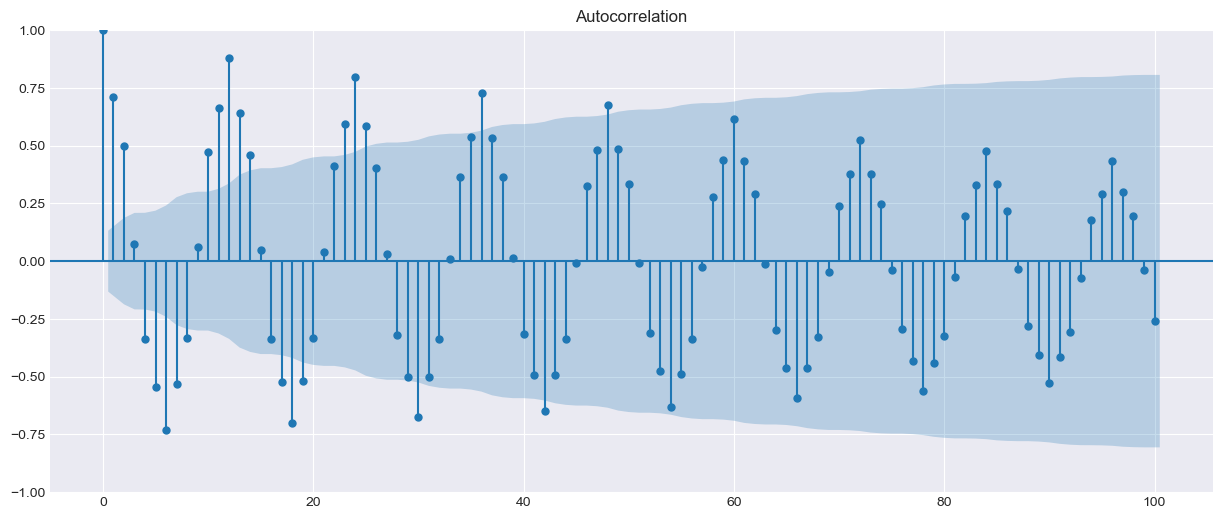

In [13]:
# Daglige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(Forbrug_og_temp_daily.GrossConsumptionMWh, ax=ax, lags=365*2)
plt.show()

# Ugentlige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(Forbrug_og_temp_weekly.GrossConsumptionMWh, ax=ax, lags=52*2)
plt.show()

# Månedlige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(Forbrug_og_temp_monthly.GrossConsumptionMWh, ax=ax, lags=100)
plt.show()


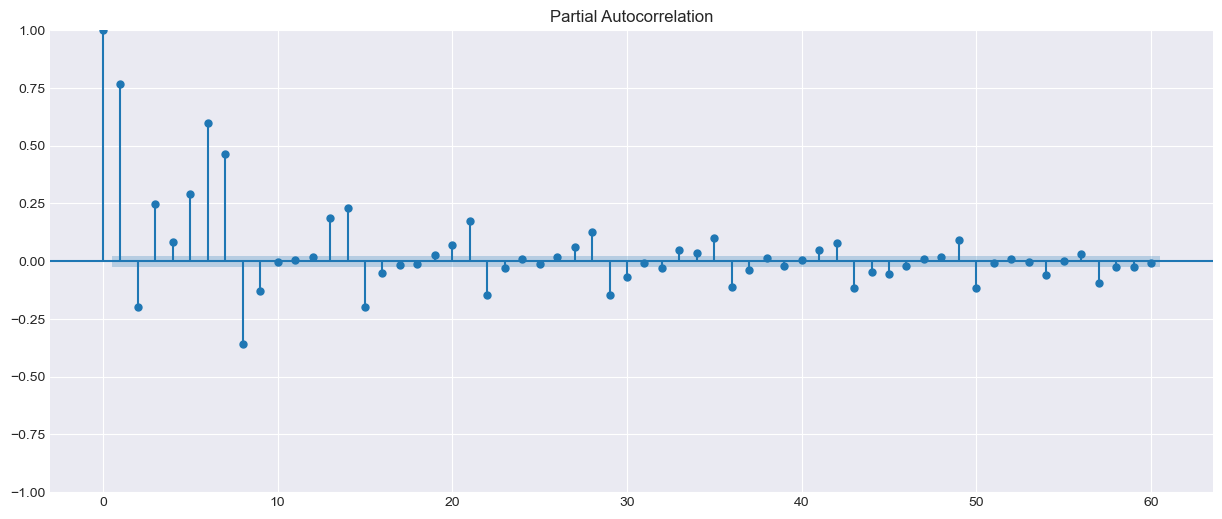

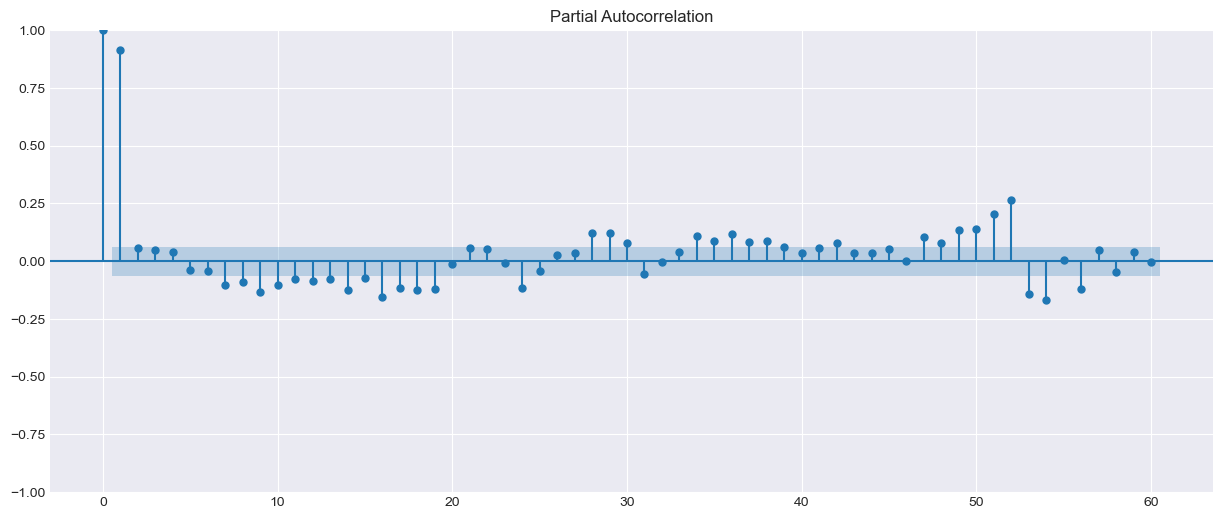

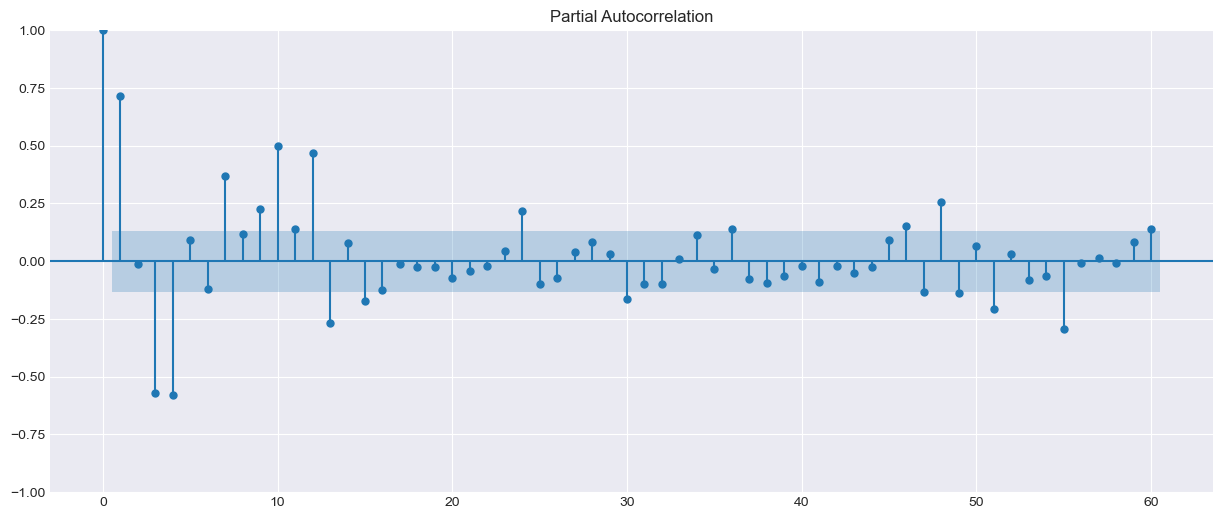

In [14]:
# Daglige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(Forbrug_og_temp_daily.GrossConsumptionMWh, ax=ax, lags=60)
plt.show()

# Ugentlige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(Forbrug_og_temp_weekly.GrossConsumptionMWh, ax=ax, lags=60)
plt.show()

# Månedlige data
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(Forbrug_og_temp_monthly.GrossConsumptionMWh, ax=ax, lags=60)
plt.show()

## Recursiv multi-step forudsigelse

En rekursiv autoregressions model (ForecasterAutoreg) er lavet og trænet fra en lineær regressions model med en Ridge penalty og et tidsvindue på lags der er valgt ud fra ACF plotsne. Dette betyder at for hver forudsigelse, er efterspørgselsværdien for de tidligere `antal lags` observationer brugt som en prædikator.

In [15]:
# Create and train forecaster for daily
# ==============================================================================
forecaster_daily = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 365,
                 transformer_y = StandardScaler()
             )

forecaster_daily.fit(y=Forbrug_og_temp_daily.loc[:end_validation, 'GrossConsumptionMWh'])
print(forecaster_daily)

# Create and train forecaster for weekly
# ==============================================================================
forecaster_weekly = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 52,
                 transformer_y = StandardScaler()
             )

forecaster_weekly.fit(y=Forbrug_og_temp_weekly.loc[:end_validation, 'GrossConsumptionMWh'])
print(forecaster_weekly)

# Create and train forecaster for monthly
# ==============================================================================
forecaster_monthly = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 12,
                 transformer_y = StandardScaler()
             )

forecaster_monthly.fit(y=Forbrug_og_temp_monthly.loc[:end_validation, 'GrossConsumptionMWh'])
print(forecaster_monthly)

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

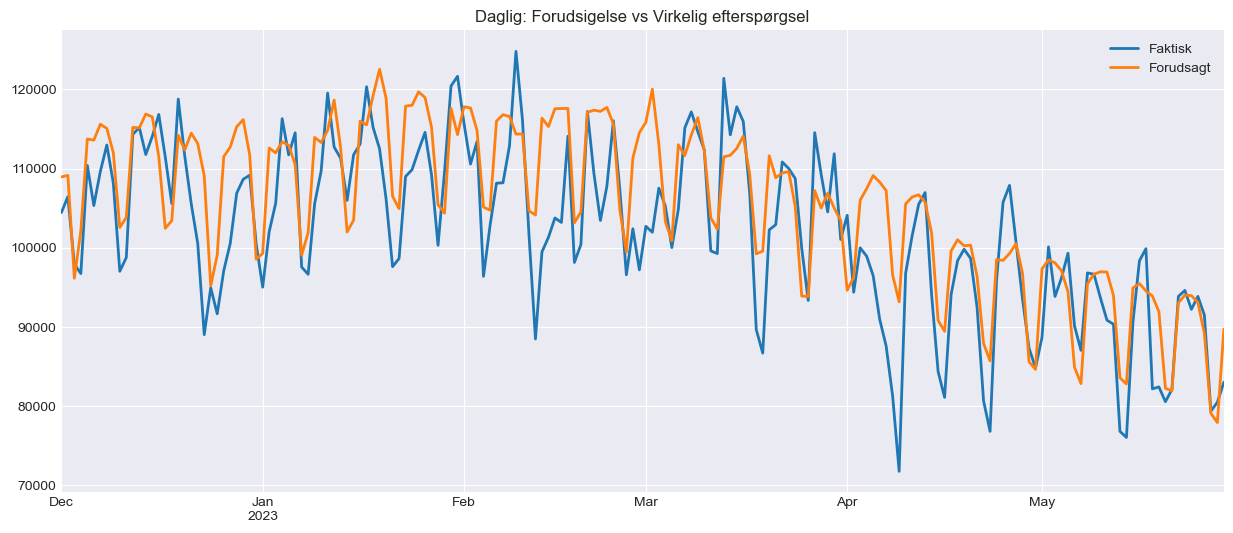

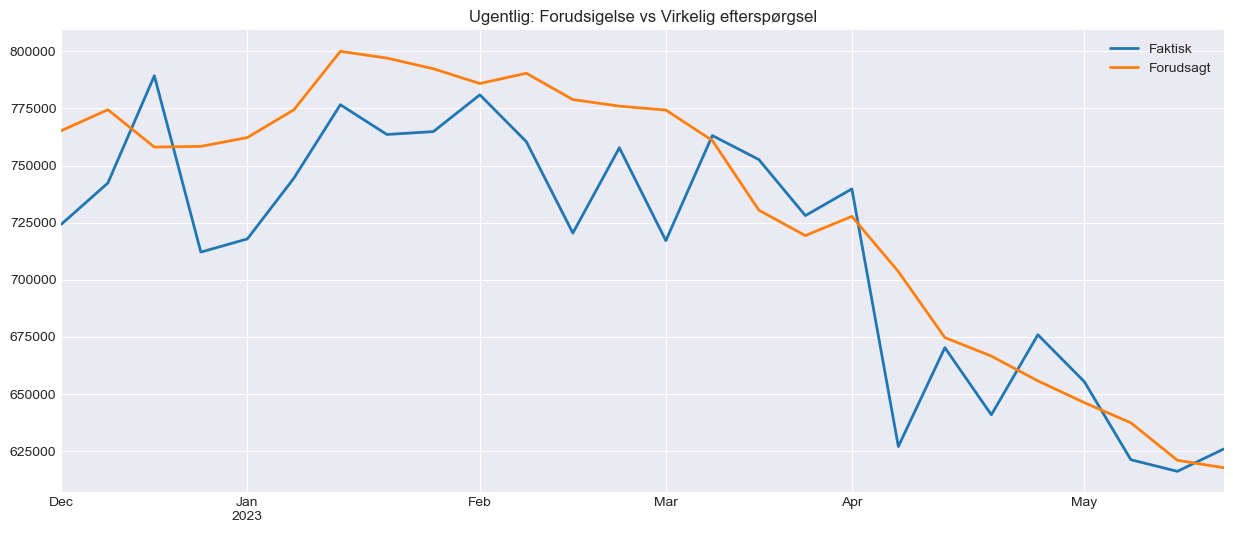

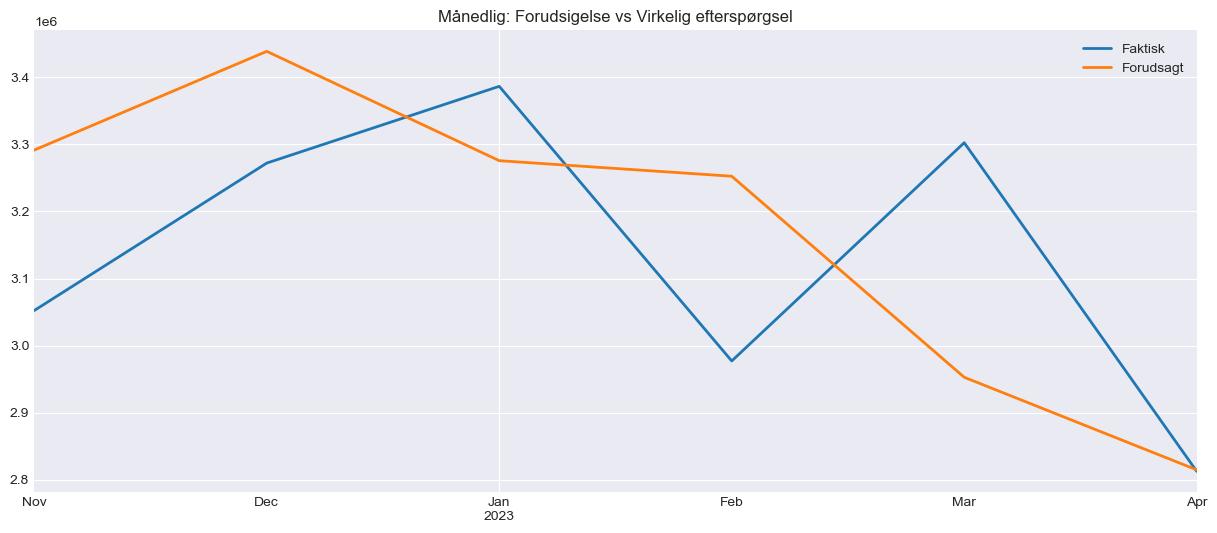

In [16]:
# Forudsig et halvt år frem for daglig data
predictions_daily = forecaster_daily.predict(steps=180)

# Forudsig et halvt år frem for ugentlig data
predictions_weekly = forecaster_weekly.predict(steps=26)

# Forudsig et halvt år frem for månedlig data
predictions_monthly = forecaster_monthly.predict(steps=6)

# Dette antager, at du vil forudsige de næste 26 uger fra slutningen af dit valideringssæt
start_date = pd.Period('2022-11-28/2022-12-04', 'W-SUN')
prediction_dates = [start_date + i for i in range(26)]
predictions_weekly.index = prediction_dates

# The target is to predict the next 7 months from the end of your validation set
start_date = pd.Period('2022-11', 'M')
prediction_dates = [start_date + i for i in range(6)]
predictions_monthly.index = prediction_dates

# Tegn daglige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
Forbrug_og_temp_daily.loc[predictions_daily.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_daily.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Daglig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

# Tegn ugentlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
Forbrug_og_temp_weekly.loc[predictions_weekly.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_weekly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Ugentlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

# Tegn månedlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
Forbrug_og_temp_monthly.loc[predictions_monthly.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_monthly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Månedlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

In [17]:
# save sum of test and predictions:
#====================== daily =======================================
sum_pred_daily=sum(predictions_daily)
sum_test_daily=sum(data_test_daily['GrossConsumptionMWh'])


Error_pct_daily=(sum_pred_daily-sum_test_daily)/sum_test_daily*100
print(f"Backtest pct error daily: {Error_pct_daily:.2f}%")

#====================== weekly =======================================
sum_pred_weekly=sum(predictions_weekly)
sum_test_weekly=sum(data_test_weekly['GrossConsumptionMWh'])


Error_pct_weekly=(sum_pred_weekly-sum_test_weekly)/sum_test_weekly*100
print(f"Backtest pct error weekly: {Error_pct_weekly:.2f}%")

#====================== monthly =======================================
sum_pred_monthly=sum(predictions_monthly)
sum_test_monthly=sum(data_test_monthly['GrossConsumptionMWh'])


Error_pct_monthly=(sum_pred_monthly-sum_test_monthly)/sum_test_monthly*100
print(f"Backtest pct error monthly: {Error_pct_monthly:.2f}%")

Backtest pct error daily: 2.83%
Backtest pct error weekly: 2.48%
Backtest pct error monthly: -11.11%


## Hyperparameter tuning af modellerne

Den trænede `ForecasterAutoreg` object bruger de første 365, 52 og 12 antal lags og en ridge model med defualt hyperparametre. Der er dog ungen grund til at disse værdier skulle være de mest passende.

For at identificere den bedste combination af lags og hyperparameter er Grid Search med validering Backtesting brugt. Denne process består af at træne en model med forskellgie kombination af parametre og lags og så evaluere dens forudsigelses kapacitet. i denne søgnings proces er det vigtigt at evaluere modelen ved at bruge validerings data og ikke inkludere test data, som kun er brugt til at evaluere den endelige model.

#### Fejl metrik
inden for tuning af modeller skal vi bruge en metrik til at sammenligne disse modeller, det kunne f.eks. være Mean Absolut Error `MEA`, eller Mean Squard Error `MSE`, men i nogen tilfælde vil man måske gerne brug en helt anden metric.
I dette projekt er vi intereseret i at vide hvor meget energi vi skal købe for det næste halveår derfor kan det at man forudsiger for højt i en måned godt udlignes at man gætter for lavt i den næste, vi er altså med andre ord kun intereseret i hvor meget summen af forudsigelserne er anderledes end summen af forbruget for det næste halve år. derfor kan vi bruge helt normal procent regning til at opstille vores metrik:

$$
\frac{\hat{y} - y}{y} \cdot 100
$$

hvor $\hat{y}$ er summen af de forudsagte værdier og $y$ er summen af de faktiske værdi. 
Men på grund af at grid search fungere på den forsøger at minimere metrikken, kan dette ikke virke da den ville finde den mest negative værdi. derfor skal vi tage den absolutte værdi af brøken:

$$
\lvert\frac{\hat{y} - y}{y}\rvert \cdot 100
$$

In [18]:
def pct_error(y_true, y_pred):
    return np.abs(np.sum(y_pred - y_true) / np.sum(y_true)) * 100

### Daglig data

In [19]:
# Hyperparameter Grid search for daily data
# ==============================================================================
forecaster_daily = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 7, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid_daily =[365-36*i for i in range(10)]

# Regressor's hyperparameters
param_grid_daily = {'alpha': np.logspace(-3, 5, 10)}

results_grid_daily = grid_search_forecaster(
                   forecaster         = forecaster_daily,
                   y                  = Forbrug_og_temp_daily.loc[:end_validation, 'GrossConsumptionMWh'],
                   steps              = 7,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid_daily,
                   lags_grid          = lags_grid_daily,
                   initial_train_size = len(Forbrug_og_temp_daily[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 100.


lags grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [20]:
results_grid_daily

,lags,params,mean_absolute_error,alpha
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 215.44346900318823},3375.459235,215.443469
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1668.1005372000557},3443.521743,1668.100537
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 215.44346900318823},3452.983861,215.443469
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 27.825594022071257},3457.213203,27.825594
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 215.44346900318823},3457.553281,215.443469
...,...,...,...,...
59,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 100000.0},5709.627023,100000.000000
69,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 100000.0},6054.831381,100000.000000
79,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 100000.0},6569.345294,100000.000000
89,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 100000.0},6895.222404,100000.000000


In [21]:
# Create and train the best model for daily data
# ==============================================================================
forecaster_daily_best = ForecasterAutoreg(
    regressor=Ridge(alpha=215.44346900318823, random_state=123),
    lags=list(range(1, 366)),
    transformer_y=StandardScaler()
)

forecaster_daily_best.fit(y=Forbrug_og_temp_daily['GrossConsumptionMWh'])

Backtest pct error daily: 2.76%


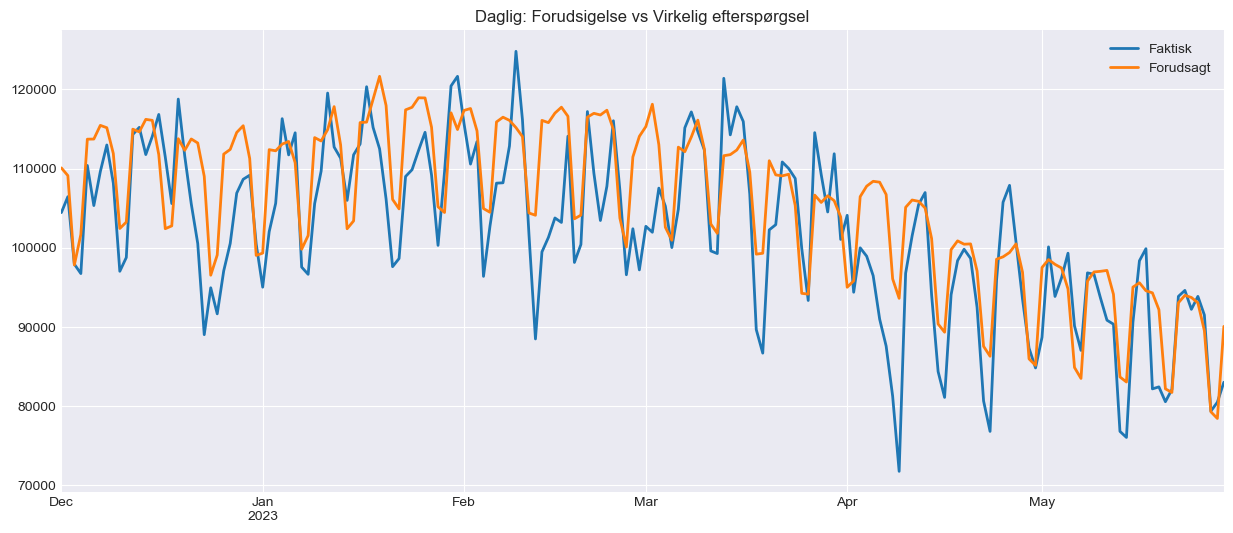

In [22]:
# Forudsig et halvt år frem for daglig data
predictions_daily = forecaster_daily.predict(steps=180)

# Tegn daglige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
Forbrug_og_temp_daily.loc[predictions_daily.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_daily.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Daglig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

# save sum of test and predictions:
#====================== daily =======================================
sum_pred_daily=sum(predictions_daily)
sum_test_daily=sum(data_test_daily['GrossConsumptionMWh'])


Error_pct_daily=(sum_pred_daily-sum_test_daily)/sum_test_daily*100
print(f"Backtest pct error daily: {Error_pct_daily:.2f}%")

### Ugenlig data

In [23]:
# Create a copy of the original dataframe and convert the index to timestamp
Forbrug_og_temp_weekly_copy = Forbrug_og_temp_weekly.copy()
Forbrug_og_temp_weekly_copy.index = Forbrug_og_temp_weekly_copy.index.to_timestamp()

# Hyperparameter Grid search for weekly data
# ==============================================================================
forecaster_weekly = ForecasterAutoreg(
    regressor     = Ridge(random_state=123),
    lags          = 52, # This value will be replaced in the grid search
    transformer_y = StandardScaler()
)

# Lags used as predictors
lags_grid_weekly = [52-36*i for i in range(10) if 52-36*i >= 1]

# Regressor's hyperparameters
param_grid_weekly = {'alpha': np.logspace(-3, 5, 10)}

results_grid_weekly = grid_search_forecaster(
    forecaster         = forecaster_weekly,
    y                  = Forbrug_og_temp_weekly_copy.loc[:end_validation, 'GrossConsumptionMWh'],
    steps              = 26, # Assuming we are forecasting 6 months (26 weeks) ahead
    metric             = 'mean_absolute_error',
    param_grid         = param_grid_weekly,
    lags_grid          = lags_grid_weekly,
    initial_train_size = len(Forbrug_og_temp_weekly_copy[:end_train]),
    refit              = False,
    return_best        = True,
    verbose            = False
)

Number of models compared: 20.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'alpha': 27.825594022071257}
  Backtesting metric: 23257.618736840213



In [24]:
# Create and train forecaster for weekly
# ==============================================================================
forecaster_weekly = ForecasterAutoreg(
                 regressor     = Ridge(alpha=27.825594022071257,random_state=123),
                 lags          = list(range(1, 53)),
                 transformer_y = StandardScaler()
             )

forecaster_weekly.fit(y=Forbrug_og_temp_weekly.loc[:end_validation, 'GrossConsumptionMWh'])

Backtest pct error weekly: 2.28%


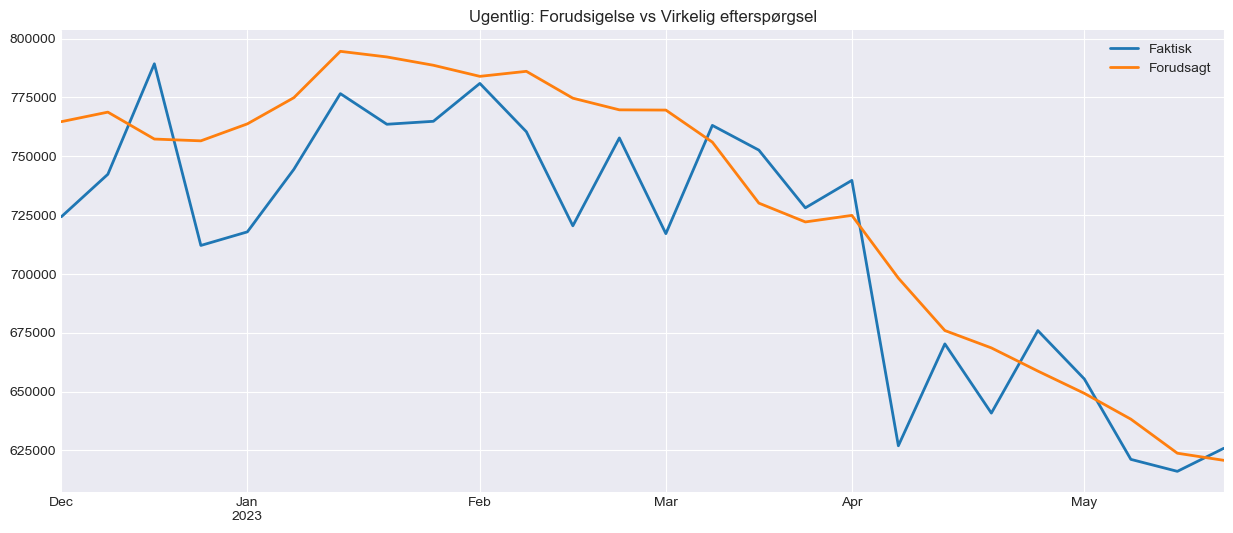

In [25]:
# Forudsig et halvt år frem for ugentlig data
predictions_weekly = forecaster_weekly.predict(steps=26)

# Dette antager, at du vil forudsige de næste 26 uger fra slutningen af dit valideringssæt
start_date = pd.Period('2022-11-28/2022-12-04', 'W-SUN')
prediction_dates = [start_date + i for i in range(26)]
predictions_weekly.index = prediction_dates

# Tegn ugentlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
Forbrug_og_temp_weekly.loc[predictions_weekly.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_weekly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Ugentlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

#====================== weekly =======================================
sum_pred_weekly=sum(predictions_weekly)
sum_test_weekly=sum(data_test_weekly['GrossConsumptionMWh'])


Error_pct_weekly=(sum_pred_weekly-sum_test_weekly)/sum_test_weekly*100
print(f"Backtest pct error weekly: {Error_pct_weekly:.2f}%")

### Månedlig Data

In [26]:
# Prepare a copy of the data for grid search (convert PeriodIndex to Timestamp)
Forbrug_og_temp_monthly_gs = Forbrug_og_temp_monthly.copy()
Forbrug_og_temp_monthly_gs.index = Forbrug_og_temp_monthly_gs.index.to_timestamp()

# Create forecaster
forecaster_monthly = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 12, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid_monthly = [12-i for i in range(10) if 12-i >= 1]

# Regressor's hyperparameters
param_grid_monthly = {'alpha': np.logspace(-3, 5, 10)}

results_grid_monthly = grid_search_forecaster(
                   forecaster         = forecaster_monthly,
                   y                  = Forbrug_og_temp_monthly_gs.loc[:end_validation, 'GrossConsumptionMWh'],
                   steps              = 6, # Assuming we are forecasting 6 months ahead
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid_monthly,
                   lags_grid          = lags_grid_monthly,
                   initial_train_size = len(Forbrug_og_temp_monthly_gs[:end_train]),
                   refit              = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 100.


lags grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 80230.78281721257



In [27]:
# Create and train forecaster for weekly
# ==============================================================================
forecaster_monthly = ForecasterAutoreg(
                 regressor     = Ridge(alpha=3.593813663804626,random_state=123),
                 lags          = list(range(1, 11)),
                 transformer_y = StandardScaler()
             )

forecaster_monthly.fit(y=Forbrug_og_temp_monthly.loc[:end_validation, 'GrossConsumptionMWh'])

Backtest pct error monthly: -13.70%


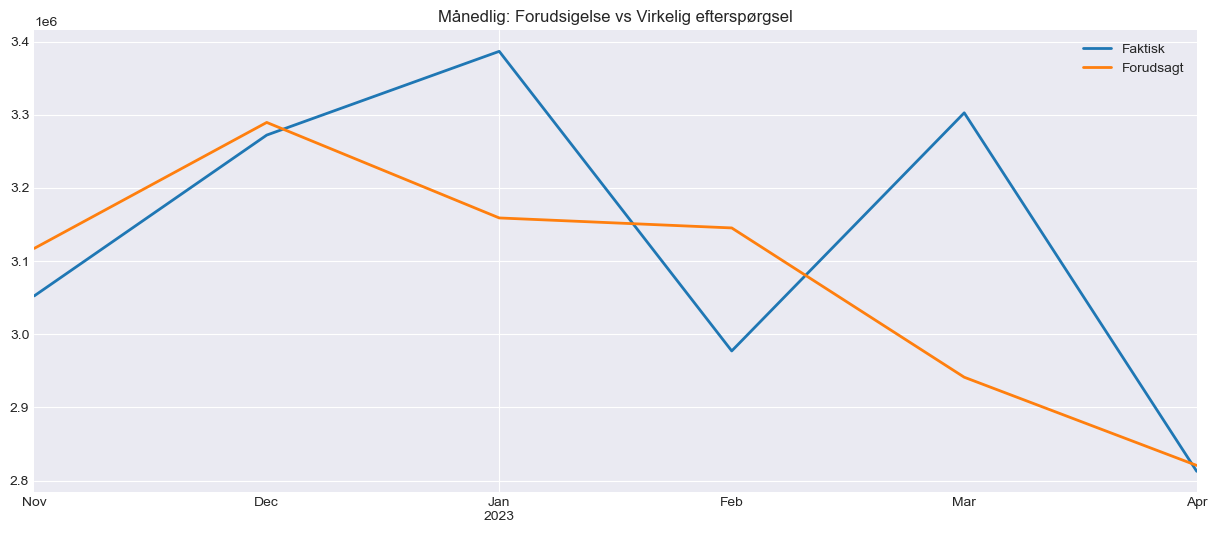

In [28]:
# Forudsig et halvt år frem for månedlig data
predictions_monthly = forecaster_monthly.predict(steps=6)

# The target is to predict the next 6 months from the end of your validation set
start_date = pd.Period('2022-11', 'M')
prediction_dates = [start_date + i for i in range(6)]
predictions_monthly.index = prediction_dates

# Tegn månedlige forudsigelser
fig, ax = plt.subplots(figsize=(15, 6))
Forbrug_og_temp_monthly.loc[predictions_monthly.index, 'GrossConsumptionMWh'].plot(ax=ax, linewidth=2, label='Faktisk')
predictions_monthly.plot(linewidth=2, label='Forudsagt', ax=ax)
ax.set_title('Månedlig: Forudsigelse vs Virkelig efterspørgsel')
ax.legend()

#====================== monthly =======================================
sum_pred_monthly=sum(predictions_monthly)
sum_test_monthly=sum(data_test_monthly['GrossConsumptionMWh'])


Error_pct_monthly=(sum_pred_monthly-sum_test_monthly)/sum_test_monthly*100
print(f"Backtest pct error monthly: {Error_pct_monthly:.2f}%")